In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_VERSION = format_pytorch_version(torch.__version__)
CUDA_VERSION = torch.version.cuda
CUDA_TAG = f"cu{CUDA_VERSION.replace('.', '')}" if CUDA_VERSION else "cpu"

print("Torch:", TORCH_VERSION, "| CUDA:", CUDA_VERSION, "| TAG:", CUDA_TAG)

!pip -q install pyg-lib -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_TAG}.html
!pip -q install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_TAG}.html
!pip -q install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+{CUDA_TAG}.html

!pip -q install torch-geometric

Torch: 2.8.0 | CUDA: 12.6 | TAG: cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, Node2Vec
from torch_geometric.utils import to_undirected

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support
)
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

PYG_OUT = ""
assert os.path.exists(PYG_OUT), "Ajuste a variável PYG_OUT para o diretório correto."

Device: cuda


### **Carregamento e normalização dos dados**

In [ ]:
PYG_OUT = ''

In [6]:
edge_index = torch.from_numpy(np.load(os.path.join(PYG_OUT, 'edge_index.npy'))).long()  # [2, E]
edge_attr  = torch.from_numpy(np.load(os.path.join(PYG_OUT, 'edge_attr.npy'))).float()  # [E, Fe]
edge_y     = torch.from_numpy(np.load(os.path.join(PYG_OUT, 'edge_y.npy'))).long()      # [E]
node_x     = torch.from_numpy(np.load(os.path.join(PYG_OUT, 'node_x.npy'))).float()     # [N, Fv]
edge_split = torch.from_numpy(np.load(os.path.join(PYG_OUT, 'edge_split.npy'))).long()  # [E] 0/1/2

N = node_x.size(0)
E = edge_index.size(1)
Fe = edge_attr.size(1)
Fv = node_x.size(1)
assert edge_attr.size(0) == E == edge_y.size(0) == edge_split.size(0)
assert edge_index.max() < N, "edge_index tem id >= N; confira mapping_accounts"

print(f"N nós={N} | E arestas={E} | Fv={Fv} (node feats) | Fe={Fe} (edge feats)")

N nós=26310 | E arestas=101358 | Fv=9 (node feats) | Fe=27 (edge feats)


In [7]:
train_mask = (edge_split == 0)
val_mask   = (edge_split == 1)
test_mask  = (edge_split == 2)

In [8]:
data = Data(x=node_x, edge_index=edge_index, edge_attr=edge_attr)
data.edge_y = edge_y
data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

data = data.to(DEVICE)

In [ ]:
def audit_tensor(name, t):
    nf = (~torch.isfinite(t)).sum().item()
    print(f"[audit] {name}: shape={tuple(t.shape)}, non-finite={nf}")

audit_tensor("node_x (raw)", data.x)
audit_tensor("edge_attr (raw)", data.edge_attr)

data.x[~torch.isfinite(data.x)] = 0.0
data.edge_attr[~torch.isfinite(data.edge_attr)] = 0.0

ea_train = data.edge_attr[data.train_mask].clone()
nx_all   = data.x.clone()

ea_std = torch.std(ea_train, dim=0, correction=0)
ea_bad = (~torch.isfinite(ea_train)).any(dim=0) | (ea_std < 1e-8)

nx_std = torch.std(nx_all, dim=0, correction=0)
nx_bad = (~torch.isfinite(nx_all)).any(dim=0) | (nx_std < 1e-8)

print(f"[audit] edge_attr drop cols: {int(ea_bad.sum())} / {data.edge_attr.shape[1]}")
print(f"[audit] node_x drop cols: {int(nx_bad.sum())} / {data.x.shape[1]}")

edge_feat_idx_keep = torch.where(~ea_bad)[0].detach().cpu().numpy()
node_feat_idx_keep = torch.where(~nx_bad)[0].detach().cpu().numpy()

keep_ea = ~ea_bad
keep_nx = ~nx_bad
data.edge_attr = data.edge_attr[:, keep_ea]
data.x         = data.x[:, keep_nx]

nx_mean = data.x.mean(dim=0)
nx_std  = torch.std(data.x, dim=0, correction=0).clamp_min(1e-6)
data.x  = (data.x - nx_mean) / nx_std

ea_train = data.edge_attr[data.train_mask]
ea_mean  = ea_train.mean(dim=0)
ea_std   = torch.std(ea_train, dim=0, correction=0).clamp_min(1e-6)
data.edge_attr = (data.edge_attr - ea_mean) / ea_std

data.x.clamp_(-8.0, 8.0)
data.edge_attr.clamp_(-8.0, 8.0)

audit_tensor("node_x (sanitized)", data.x)
audit_tensor("edge_attr (sanitized)", data.edge_attr)

Fv = data.x.size(1)
Fe = data.edge_attr.size(1)
print(f"[dims] Fv={Fv}, Fe={Fe}")

assert Fe > 0, "nenhuma feature de aresta restante após saneamento."
assert Fv > 0, "nenhuma feature de nó restante após saneamento."

meta_sane_path = os.path.join(os.path.dirname(PYG_OUT), 'sane_keep_indices.json')
with open(meta_sane_path, 'w') as f:
    json.dump({
        "edge_feat_idx_keep": edge_feat_idx_keep.tolist(),
        "node_feat_idx_keep": node_feat_idx_keep.tolist()
    }, f, indent=2)

print("metadados de saneamento salvos em:", meta_sane_path)

### **Funções utilitárias**

In [10]:
def class_weights_from_mask(y, mask):
    #retorna pesos para CrossEntropy (inverso da frequência por classe)
    y_np = y[mask].detach().cpu().numpy()
    if y_np.size == 0:
        return None
    classes, counts = np.unique(y_np, return_counts=True)
    total = counts.sum()
    w = np.zeros(int(classes.max())+1, dtype=np.float32)
    for c, cnt in zip(classes, counts):
        w[int(c)] = total / (len(classes)*cnt)
    return torch.tensor(w, dtype=torch.float32, device=DEVICE)

In [11]:
@torch.no_grad()
def compute_metrics(logits, y_true):
    #retorna acc, precision, recall, f1 macro
    y_pred = logits.argmax(dim=1).detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', pos_label=1, zero_division=0
    )
    return acc, prec, rec, f1

In [12]:
def train_one_epoch(model, data, optimizer, criterion, max_norm=2.0):
    model.train()
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits[data.train_mask], data.edge_y[data.train_mask])
    if not torch.isfinite(loss):
        print("loss não-finita detectada; abortando backprop desta iteração.")
        return float('nan'), (np.nan,)*4, (np.nan,)*4
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)  # <= grad clipping
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits_eval = model(data)
        tr = compute_metrics(logits_eval[data.train_mask], data.edge_y[data.train_mask]) if data.train_mask.any() else (np.nan,)*4
        va = compute_metrics(logits_eval[data.val_mask],   data.edge_y[data.val_mask])   if data.val_mask.any()   else (np.nan,)*4
    return float(loss.item()), tr, va

In [13]:
@torch.no_grad()
def evaluate_on_mask(model, data, mask):
    model.eval()
    logits = model(data)
    return compute_metrics(logits[mask], data.edge_y[mask])

### **Modelos**

In [14]:
# Baseline A: MLP só em edge_attr
class EdgeMLP(nn.Module):
    #ignora o grafo e classifica usando apenas edge_attr
    def __init__(self, edge_feat_dim, hidden=128, out_classes=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_classes)
        )
    def forward(self, data):
        return self.mlp(data.edge_attr)

In [15]:
# Baseline B: Node2Vec + MLP(edge)
class EdgeMLPWithNode2Vec(nn.Module):
    #Node2Vec para embeddings de nó + MLP em [h_u, h_v, edge_attr]
    def __init__(self, node2vec_emb, edge_feat_dim, hidden=128, out_classes=2):
        super().__init__()
        self.emb = node2vec_emb  #nn.Embedding (pré-treinado abaixo)
        emb_dim = self.emb.embedding_dim
        self.mlp = nn.Sequential(
            nn.Linear(2*emb_dim + edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_classes)
        )
    def forward(self, data):
        src, dst = data.edge_index
        h_u = self.emb(src)
        h_v = self.emb(dst)
        z = torch.cat([h_u, h_v, data.edge_attr], dim=1)
        return self.mlp(z)

In [16]:
# Modelo proposto: GraphSAGE + MLP(edge)
class EdgeClassifierSAGE(nn.Module):
    #GraphSAGE para h de nós + MLP em [h_u, h_v, edge_attr]
    def __init__(self, in_node, edge_feat_dim, hidden=64, layers=2, out_classes=2):
        super().__init__()
        self.convs = nn.ModuleList([SAGEConv(in_node, hidden)])
        for _ in range(layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.act = nn.ReLU()
        self.mlp = nn.Sequential(
            nn.Linear(2*hidden + edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_classes)
        )
    def forward(self, data):
        h = data.x
        for conv in self.convs:
            h = self.act(conv(h, data.edge_index))
        src, dst = data.edge_index
        z = torch.cat([h[src], h[dst], data.edge_attr], dim=1)
        return self.mlp(z)

### **Treinamento dos modelos**

In [17]:
EPOCHS = 20
results_history = {}
final_test_metrics = {}

In [18]:
print("distribuição no TREINO:", np.bincount(data.edge_y[data.train_mask].cpu().numpy(), minlength=2))

distribuição no TREINO: [68046  2901]


#### Baseline A

In [19]:
def class_weights_balanced(y, mask, num_classes=2, device='cpu'):
    y_np = y[mask].detach().cpu().numpy()
    counts = np.bincount(y_np, minlength=num_classes).astype(float)  # [C]
    n_samples = counts.sum()
    weights = n_samples / (num_classes * counts)
    return torch.tensor(weights, dtype=torch.float32, device=device)

In [20]:
train_counts = np.bincount(data.edge_y[data.train_mask].detach().cpu().numpy(), minlength=2)
print("Distribuição no TREINO:", train_counts)
wA = class_weights_balanced(data.edge_y, data.train_mask, num_classes=2, device=DEVICE)
print("Pesos (CrossEntropy) -> [w0, w1]:", wA.detach().cpu().numpy())

Distribuição no TREINO: [68046  2901]
Pesos (CrossEntropy) -> [w0, w1]: [ 0.52131647 12.2280245 ]


In [21]:
torch.manual_seed(42)
modelA = EdgeMLP(edge_feat_dim=Fe, hidden=128, out_classes=2).to(DEVICE)

critA = nn.CrossEntropyLoss(weight=wA)
optA  = torch.optim.Adam(modelA.parameters(), lr=1e-3)

histA = {'train_acc':[], 'train_prec':[], 'train_rec':[], 'train_f1':[],
         'val_acc':[], 'val_prec':[], 'val_rec':[], 'val_f1':[], 'loss':[]}

for ep in range(1, EPOCHS+1):
    loss, tr, va = train_one_epoch(modelA, data, optA, critA)
    histA['loss'].append(loss)
    (ta, tp, trc, tf1) = tr
    (va_acc, va_prec, va_rec, va_f1) = va
    histA['train_acc'].append(ta);   histA['train_prec'].append(tp);   histA['train_rec'].append(trc);  histA['train_f1'].append(tf1)
    histA['val_acc'].append(va_acc); histA['val_prec'].append(va_prec); histA['val_rec'].append(va_rec); histA['val_f1'].append(va_f1)
    print(f"[A][{ep:02d}] loss={loss:.4f} | "
          f"train: acc={ta:.3f} p={tp:.3f} r={trc:.3f} f1={tf1:.3f} | "
          f"val: acc={va_acc:.3f} p={va_prec:.3f} r={va_rec:.3f} f1={va_f1:.3f}")

testA = evaluate_on_mask(modelA, data, data.test_mask)
final_test_metrics['Baseline_MLP'] = {'acc':testA[0], 'prec':testA[1], 'rec':testA[2], 'f1':testA[3]}
results_history['Baseline_MLP'] = histA
print("Teste [A] acc,prec,rec,f1 =", testA)

[A][01] loss=0.6966 | train: acc=0.047 p=0.041 r=0.999 f1=0.079 | val: acc=0.065 p=0.049 r=1.000 f1=0.094
[A][02] loss=0.6865 | train: acc=0.125 p=0.044 r=0.988 f1=0.084 | val: acc=0.298 p=0.063 r=0.973 f1=0.118
[A][03] loss=0.6766 | train: acc=0.306 p=0.054 r=0.975 f1=0.103 | val: acc=0.621 p=0.108 r=0.944 f1=0.194
[A][04] loss=0.6670 | train: acc=0.463 p=0.068 r=0.959 f1=0.127 | val: acc=0.798 p=0.183 r=0.913 f1=0.304
[A][05] loss=0.6573 | train: acc=0.555 p=0.080 r=0.938 f1=0.147 | val: acc=0.870 p=0.257 r=0.890 f1=0.399
[A][06] loss=0.6477 | train: acc=0.605 p=0.088 r=0.920 f1=0.160 | val: acc=0.904 p=0.320 r=0.871 f1=0.468
[A][07] loss=0.6378 | train: acc=0.635 p=0.093 r=0.908 f1=0.169 | val: acc=0.924 p=0.374 r=0.851 f1=0.520
[A][08] loss=0.6277 | train: acc=0.655 p=0.097 r=0.900 f1=0.176 | val: acc=0.935 p=0.415 r=0.846 f1=0.557
[A][09] loss=0.6173 | train: acc=0.669 p=0.101 r=0.894 f1=0.181 | val: acc=0.940 p=0.439 r=0.837 f1=0.576
[A][10] loss=0.6065 | train: acc=0.680 p=0.103

#### Baseline B

In [22]:
EPOCHS_N2V     = 15
EMB_DIM_N2V    = 64
WALK_LENGTH    = 20
CONTEXT_SIZE   = 10
WALKS_PER_NODE = 10
NEG_SAMPLES    = 1
LR_N2V         = 0.01
BATCH_N2V      = 2048

edge_index_und = to_undirected(data.edge_index)

node2vec = Node2Vec(
    edge_index_und,
    embedding_dim=EMB_DIM_N2V,
    walk_length=WALK_LENGTH,
    context_size=CONTEXT_SIZE,
    walks_per_node=WALKS_PER_NODE,
    num_negative_samples=NEG_SAMPLES,
    p=1.0, q=1.0,
    sparse=True
).to(DEVICE)

optN2V = torch.optim.SparseAdam(node2vec.parameters(), lr=LR_N2V)
loader = node2vec.loader(batch_size=BATCH_N2V, shuffle=True, num_workers=0)

def train_node2vec(epochs=EPOCHS_N2V):
    node2vec.train()
    for e in range(1, epochs+1):
        total = 0.0
        for pos_rw, neg_rw in loader:
            pos_rw, neg_rw = pos_rw.to(DEVICE), neg_rw.to(DEVICE)
            optN2V.zero_grad()
            loss = node2vec.loss(pos_rw, neg_rw)
            loss.backward()
            optN2V.step()
            total += float(loss)
        print(f"[Node2Vec] epoch {e}/{epochs} loss={total/len(loader):.4f}")

train_node2vec()
print()

with torch.no_grad():
    emb_table = node2vec.embedding.weight.detach()

node_emb_layer = nn.Embedding.from_pretrained(emb_table, freeze=True)

torch.manual_seed(42)
modelB = EdgeMLPWithNode2Vec(
    node2vec_emb=node_emb_layer,
    edge_feat_dim=Fe,
    hidden=128,
    out_classes=2
).to(DEVICE)

wB   = class_weights_balanced(data.edge_y, data.train_mask, num_classes=2, device=DEVICE)
critB= nn.CrossEntropyLoss(weight=wB)
optB = torch.optim.Adam(modelB.parameters(), lr=1e-3)

histB = {'train_acc':[], 'train_prec':[], 'train_rec':[], 'train_f1':[],
         'val_acc':[], 'val_prec':[], 'val_rec':[], 'val_f1':[], 'loss':[]}

for ep in range(1, EPOCHS+1):
    loss, tr, va = train_one_epoch(modelB, data, optB, critB)
    histB['loss'].append(loss)
    (ta, tp, trc, tf1) = tr
    (va_acc, va_prec, va_rec, va_f1) = va
    histB['train_acc'].append(ta);   histB['train_prec'].append(tp);   histB['train_rec'].append(trc);  histB['train_f1'].append(tf1)
    histB['val_acc'].append(va_acc); histB['val_prec'].append(va_prec); histB['val_rec'].append(va_rec); histB['val_f1'].append(va_f1)
    print(f"[B][{ep:02d}] loss={loss:.4f} | train: acc={ta:.3f} p={tp:.3f} r={trc:.3f} f1={tf1:.3f} | "
          f"val: acc={va_acc:.3f} p={va_prec:.3f} r={va_rec:.3f} f1={va_f1:.3f}")

testB = evaluate_on_mask(modelB, data, data.test_mask)
final_test_metrics['Node2Vec_MLP'] = {'acc':testB[0], 'prec':testB[1], 'rec':testB[2], 'f1':testB[3]}
results_history['Node2Vec_MLP'] = histB
print("Teste [B] acc,prec,rec,f1 =", testB)

/tmp/ipython-input-2688086986.py:36: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total += float(loss)


[Node2Vec] epoch 1/15 loss=4.8183
[Node2Vec] epoch 2/15 loss=3.6667
[Node2Vec] epoch 3/15 loss=3.0325
[Node2Vec] epoch 4/15 loss=2.6561
[Node2Vec] epoch 5/15 loss=2.3865
[Node2Vec] epoch 6/15 loss=2.1686
[Node2Vec] epoch 7/15 loss=1.9832
[Node2Vec] epoch 8/15 loss=1.8204
[Node2Vec] epoch 9/15 loss=1.6799
[Node2Vec] epoch 10/15 loss=1.5590
[Node2Vec] epoch 11/15 loss=1.4531
[Node2Vec] epoch 12/15 loss=1.3655
[Node2Vec] epoch 13/15 loss=1.2900
[Node2Vec] epoch 14/15 loss=1.2269
[Node2Vec] epoch 15/15 loss=1.1725

[B][01] loss=0.6940 | train: acc=0.249 p=0.046 r=0.883 f1=0.088 | val: acc=0.337 p=0.062 r=0.898 f1=0.116
[B][02] loss=0.6866 | train: acc=0.464 p=0.058 r=0.802 f1=0.109 | val: acc=0.625 p=0.097 r=0.810 f1=0.173
[B][03] loss=0.6796 | train: acc=0.610 p=0.075 r=0.753 f1=0.136 | val: acc=0.784 p=0.148 r=0.726 f1=0.246
[B][04] loss=0.6725 | train: acc=0.680 p=0.088 r=0.729 f1=0.157 | val: acc=0.846 p=0.194 r=0.690 f1=0.303
[B][05] loss=0.6652 | train: acc=0.709 p=0.096 r=0.725 f1=0

#### Modelo proposto

In [23]:
torch.manual_seed(42)
modelC = EdgeClassifierSAGE(in_node=Fv, edge_feat_dim=Fe, hidden=64, layers=2, out_classes=2).to(DEVICE)
wC = class_weights_from_mask(data.edge_y, data.train_mask)
critC = nn.CrossEntropyLoss(weight=wC)
optC  = torch.optim.Adam(modelC.parameters(), lr=1e-3)

histC = {'train_acc':[], 'train_prec':[], 'train_rec':[], 'train_f1':[],
         'val_acc':[], 'val_prec':[], 'val_rec':[], 'val_f1':[], 'loss':[]}

for ep in range(1, EPOCHS+1):
    loss, tr, va = train_one_epoch(modelC, data, optC, critC)
    histC['loss'].append(loss)
    (ta, tp, trc, tf1) = tr
    (va_acc, va_prec, va_rec, va_f1) = va
    histC['train_acc'].append(ta);   histC['train_prec'].append(tp);   histC['train_rec'].append(trc);  histC['train_f1'].append(tf1)
    histC['val_acc'].append(va_acc); histC['val_prec'].append(va_prec); histC['val_rec'].append(va_rec); histC['val_f1'].append(va_f1)
    print(f"[C][{ep:02d}] loss={loss:.4f} | "
          f"train: acc={ta:.3f} p={tp:.3f} r={trc:.3f} f1={tf1:.3f} | "
          f"val: acc={va_acc:.3f} p={va_prec:.3f} r={va_rec:.3f} f1={va_f1:.3f}")

testC = evaluate_on_mask(modelC, data, data.test_mask)
final_test_metrics['GraphSAGE+MLP'] = {'acc':testC[0], 'prec':testC[1], 'rec':testC[2], 'f1':testC[3]}
results_history['GraphSAGE+MLP'] = histC
print("Teste [C] acc,prec,rec,f1 =", testC)

[C][01] loss=0.7119 | train: acc=0.378 p=0.045 r=0.696 f1=0.084 | val: acc=0.188 p=0.038 r=0.643 f1=0.071
[C][02] loss=0.6920 | train: acc=0.626 p=0.084 r=0.821 f1=0.152 | val: acc=0.464 p=0.065 r=0.751 f1=0.119
[C][03] loss=0.6740 | train: acc=0.754 p=0.130 r=0.884 f1=0.227 | val: acc=0.755 p=0.148 r=0.853 f1=0.252
[C][04] loss=0.6570 | train: acc=0.794 p=0.155 r=0.909 f1=0.265 | val: acc=0.878 p=0.270 r=0.890 f1=0.414
[C][05] loss=0.6405 | train: acc=0.809 p=0.166 r=0.912 f1=0.281 | val: acc=0.904 p=0.324 r=0.898 f1=0.476
[C][06] loss=0.6239 | train: acc=0.817 p=0.173 r=0.915 f1=0.290 | val: acc=0.914 p=0.349 r=0.901 f1=0.503
[C][07] loss=0.6073 | train: acc=0.821 p=0.176 r=0.916 f1=0.295 | val: acc=0.917 p=0.359 r=0.905 f1=0.514
[C][08] loss=0.5903 | train: acc=0.822 p=0.177 r=0.919 f1=0.297 | val: acc=0.921 p=0.371 r=0.909 f1=0.527
[C][09] loss=0.5732 | train: acc=0.822 p=0.177 r=0.922 f1=0.298 | val: acc=0.923 p=0.378 r=0.913 f1=0.535
[C][10] loss=0.5558 | train: acc=0.821 p=0.176

### **Comparativo dos resultados**

In [24]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
)
from sklearn.metrics import ConfusionMatrixDisplay
import torch

In [25]:
@torch.no_grad()
def _logits_p1(model, data):
    model.eval()
    logits = model(data)
    p1 = torch.softmax(logits, dim=1)[:, 1]
    return logits, p1

def _metrics_from(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', pos_label=1, zero_division=0
    )
    return acc, prec, rec, f1

def evaluate_model(name, model, data, thresholds=None, do_plots=True, registry=None):
    _, p1_all = _logits_p1(model, data)
    y_all = data.edge_y.detach().cpu().numpy()
    val_idx  = data.val_mask.detach().cpu().numpy()
    test_idx = data.test_mask.detach().cpu().numpy()
    p1_val, y_val   = p1_all[val_idx].cpu().numpy(),  y_all[val_idx]
    p1_test, y_test = p1_all[test_idx].cpu().numpy(), y_all[test_idx]

    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)
    sweep_rows = []
    for t in thresholds:
        yv_pred = (p1_val >= t).astype(np.int64)
        acc, prec, rec, f1 = _metrics_from(y_val, yv_pred)
        sweep_rows.append({'threshold': t, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
    df_sweep = pd.DataFrame(sweep_rows).sort_values('f1', ascending=False).reset_index(drop=True)

    best_thr = float(df_sweep.iloc[0]['threshold']) if len(df_sweep) and df_sweep['f1'].max() > 0 else 0.5
    print(f"[{name}] best threshold (val) = {best_thr:.2f}  |  val F1 = {df_sweep.iloc[0]['f1']:.3f}" if len(df_sweep) else f"[{name}] best threshold (val) = {best_thr:.2f}")

    y_pred_test = (p1_test >= best_thr).astype(np.int64)
    acc, prec, rec, f1 = _metrics_from(y_test, y_pred_test)
    auroc = roc_auc_score(y_test, p1_test)
    auprc = average_precision_score(y_test, p1_test)
    print(f"[{name}][TEST @thr={best_thr:.2f}] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}  |  AUROC={auroc:.3f}  AUPRC={auprc:.3f}")

    if do_plots:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        ax_pr, ax_roc, ax_cm = axes

        # PR
        pr_prec, pr_rec, _ = precision_recall_curve(y_test, p1_test)
        ax_pr.plot(pr_rec, pr_prec)
        ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
        ax_pr.set_title(f"PR (TEST) - {name}")
        ax_pr.grid(True, alpha=0.3)

        # ROC
        fpr, tpr, _ = roc_curve(y_test, p1_test)
        ax_roc.plot(fpr, tpr)
        ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
        ax_roc.set_title(f"ROC (TEST) - {name}")
        ax_roc.grid(True, alpha=0.3)

        # Confusion Matrix no eixo ax_cm
        cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
        disp = ConfusionMatrixDisplay(cm, display_labels=['Lícita(0)','Ilícita(1)'])
        disp.plot(values_format='d', cmap='Blues', ax=ax_cm, colorbar=False)
        ax_cm.set_title(f"Confusion (thr={best_thr:.2f})")

        fig.suptitle(f"{name} — TEST", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()

    result = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'auroc':auroc, 'auprc':auprc, 'thr':best_thr}
    if registry is not None:
        registry[name] = result
    return result, df_sweep


In [26]:
final_test_metrics = {}

[Baseline_MLP] best threshold (val) = 0.60  |  val F1 = 0.748
[Baseline_MLP][TEST @thr=0.60] acc=0.945  prec=0.751  rec=0.686  f1=0.717  |  AUROC=0.936  AUPRC=0.772


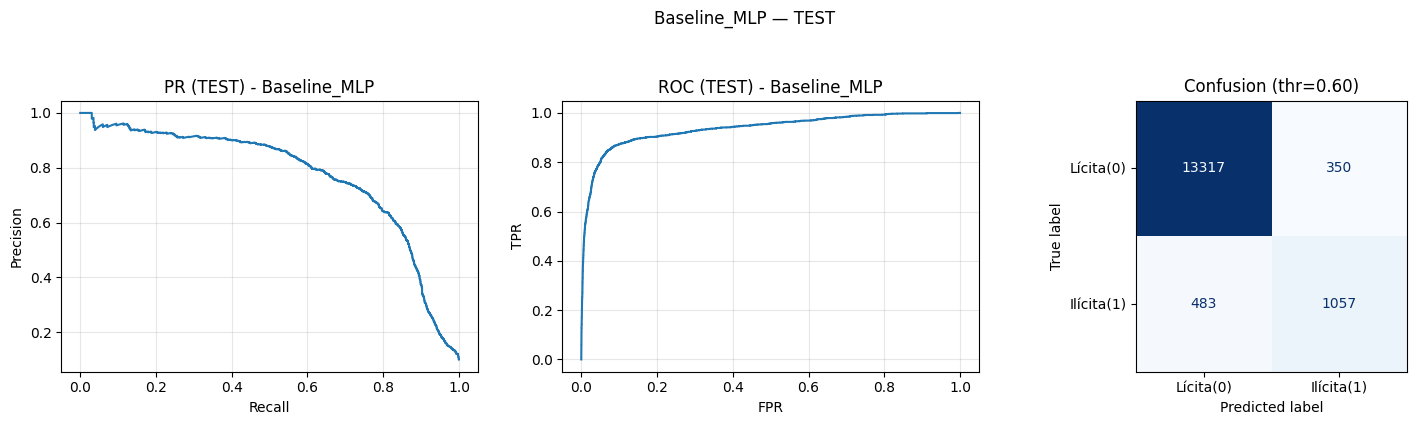

In [27]:
resA, sweepA = evaluate_model("Baseline_MLP",  modelA, data, registry=final_test_metrics)

[Node2Vec_MLP] best threshold (val) = 0.60  |  val F1 = 0.589
[Node2Vec_MLP][TEST @thr=0.60] acc=0.925  prec=0.704  rec=0.444  f1=0.545  |  AUROC=0.908  AUPRC=0.619


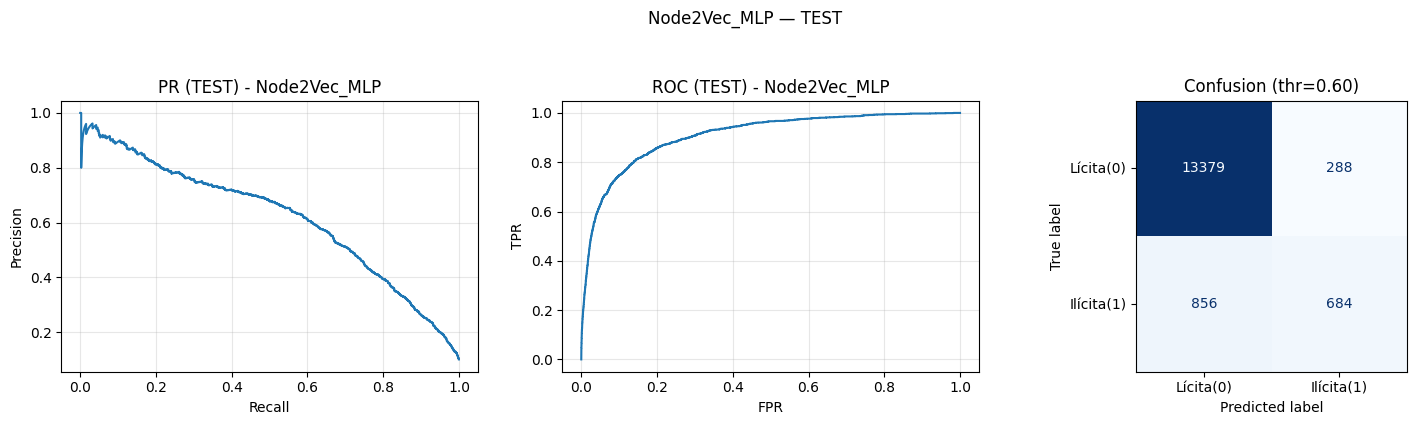

In [28]:
resB, sweepB = evaluate_model("Node2Vec_MLP",  modelB, data, registry=final_test_metrics)

[GraphSAGE+MLP] best threshold (val) = 0.65  |  val F1 = 0.761
[GraphSAGE+MLP][TEST @thr=0.65] acc=0.966  prec=0.836  rec=0.829  f1=0.832  |  AUROC=0.963  AUPRC=0.860


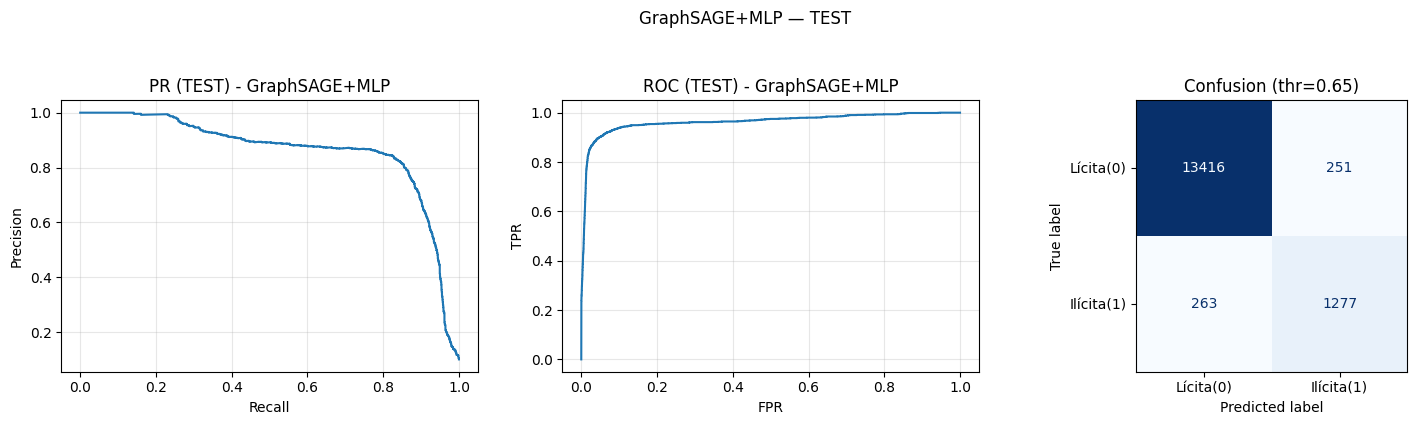

In [29]:
resC, sweepC = evaluate_model("GraphSAGE+MLP", modelC, data, registry=final_test_metrics)

In [30]:
df_comp = pd.DataFrame.from_dict(final_test_metrics, orient='index') \
         .loc[:, ['acc','prec','rec','f1','auroc','auprc','thr']] \
         .sort_values('f1', ascending=False)
display(df_comp)

,acc,prec,rec,f1,auroc,auprc,thr
GraphSAGE+MLP,0.966200,0.835733,0.829221,0.832464,0.962994,0.860468,0.65
Baseline_MLP,0.945223,0.751244,0.686364,0.717340,0.936414,0.771831,0.60
Node2Vec_MLP,0.924771,0.703704,0.444156,0.544586,0.908071,0.619200,0.60


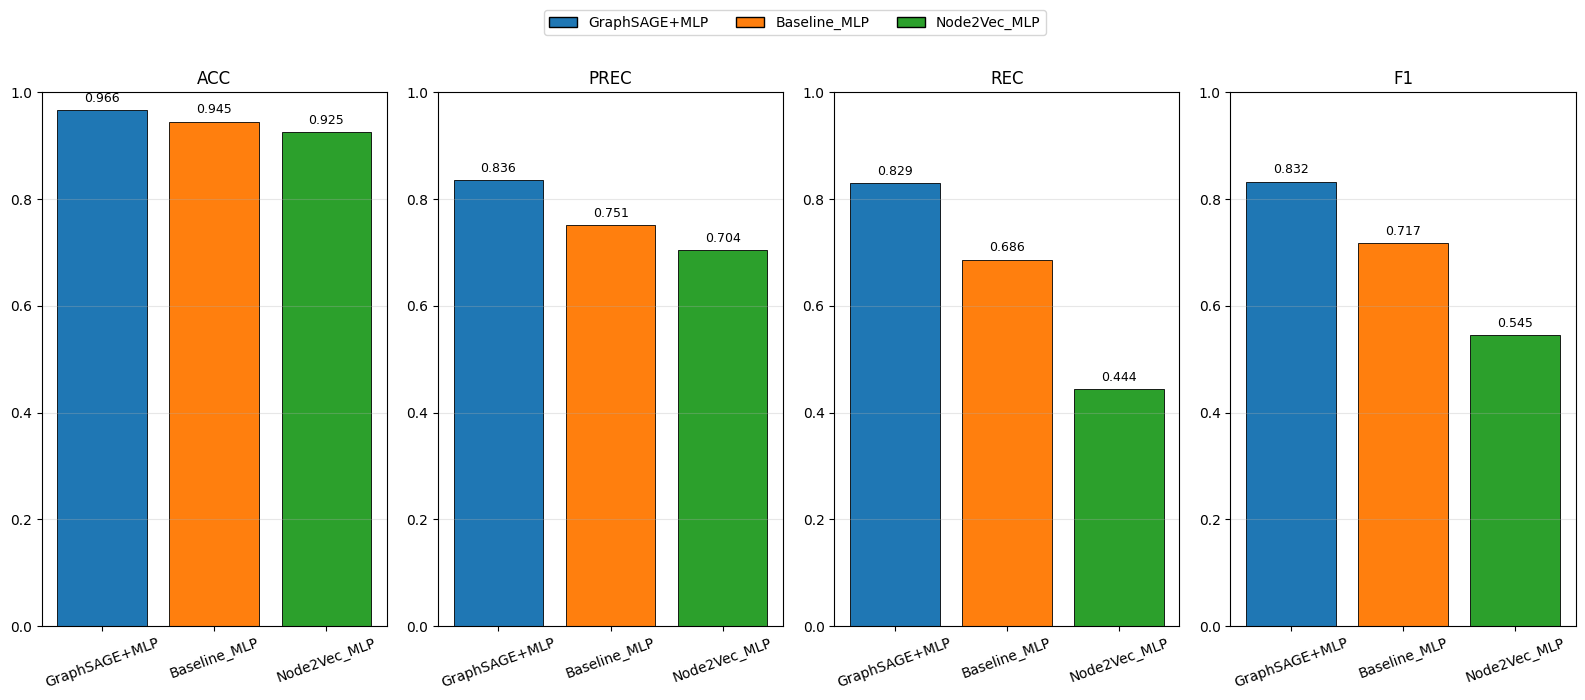

In [31]:
from matplotlib.patches import Patch

metrics = ['acc','prec','rec','f1']
models  = df_comp.index.tolist()

tab = plt.get_cmap('tab10').colors
model_colors = {m: tab[i % len(tab)] for i, m in enumerate(models)}

fig, axes = plt.subplots(1, 4, figsize=(16, 6.5), sharex=False)

for i, m in enumerate(metrics):
    vals = df_comp[m].values
    bar_colors = [model_colors[mod] for mod in models]
    bars = axes[i].bar(models, vals, color=bar_colors, edgecolor='black', linewidth=0.6)

    axes[i].set_title(m.upper())
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, axis='y', alpha=0.3)
    axes[i].tick_params(axis='x', rotation=20)

    for b, v in zip(bars, vals):
        axes[i].text(
            b.get_x() + b.get_width()/2,
            min(0.98, v) + 0.01,
            f"{v:.3f}",
            ha='center', va='bottom', fontsize=9
        )

handles = [Patch(facecolor=model_colors[m], edgecolor='black', label=m) for m in models]
fig.legend(handles=handles, loc='upper center', ncol=len(models), bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()
plt.show()

In [ ]:
OUT_DIR = os.path.dirname(PYG_OUT)
comp_path = os.path.join(OUT_DIR, 'baseline_vs_model_test_metrics.csv')
df_comp.to_csv(comp_path, index=True)
print("comparação salva em:", comp_path)

### **Salvando artefatos**

In [ ]:
import os, json, numpy as np, torch

SAVE_DIR = os.path.join(os.path.dirname(PYG_OUT), "deploy_artifacts_graphsage")
os.makedirs(SAVE_DIR, exist_ok=True)

model_ckpt = os.path.join(SAVE_DIR, "modelC_state_dict.pt")
torch.save(modelC.state_dict(), model_ckpt)

deploy_cfg = {
    "model_name": "GraphSAGE+MLP_edge",
    "hidden": 128,
    "out_classes": 2,
    "sage_aggr": "mean",
    "Fe": int(data.edge_attr.size(1)),
    "Fv": int(data.x.size(1)),
    "best_threshold": float(resC[0] if isinstance(resC, tuple) else resC.get("thr", 0.5))  # ajuste se usou outra variável
}
if isinstance(resC, tuple):
    pass
else:
    deploy_cfg["best_threshold"] = float(resC["thr"])
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(deploy_cfg, f, indent=2)

np.savez_compressed(
    os.path.join(SAVE_DIR, "scalers_and_keepidx.npz"),
    nx_mean=nx_mean.detach().cpu().numpy(),
    nx_std=nx_std.detach().cpu().numpy(),
    ea_mean=ea_mean.detach().cpu().numpy(),
    ea_std=ea_std.detach().cpu().numpy(),
    edge_feat_idx_keep=edge_feat_idx_keep,
    node_feat_idx_keep=node_feat_idx_keep
)

np.save(os.path.join(SAVE_DIR, "edge_index.npy"), data.edge_index.detach().cpu().numpy())
np.save(os.path.join(SAVE_DIR, "node_x.npy"),       data.x.detach().cpu().numpy())
np.save(os.path.join(SAVE_DIR, "edge_feat_names_idx.npy"), np.arange(deploy_cfg["Fe"]))

try:
    nodes_export_path = os.path.join(SAVE_DIR, "nodes_mapping.parquet")
    nodes[['node_id','account']].to_parquet(nodes_export_path, index=False)
except Exception as e:
    print("Erro: ", e)

print("artefatos salvos em:", SAVE_DIR)